# Anomaly Detection

In [3]:
# import libraries
%matplotlib inline
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import datetime

In [4]:
# create DataFrame
users=[]
with open('../../hduser1/Yelp/user.json') as json_file:
    for line in json_file:
        users.append(json.loads(line))
user_df = pd.DataFrame(users)

In [5]:
review=[]
with open('../../hduser1/Yelp/review.json') as json_file:
    for line in json_file:
        review.append(json.loads(line))
review_df = pd.DataFrame(review)

In [6]:
user_df.head(1)

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,elite,fans,friends,funny,name,review_count,type,useful,user_id,yelping_since
0,3.59,4192,79,4192,3904,19,305,4705,1347,2617,...,"[2017, 2015, 2016, 2014, 2011, 2013, 2012]",298,"[iJg9ekPzF9lkMuvjKYX6uA, ctWAuzS04Xu0lke2Rop4l...",12316,Rob,761,user,18456,EZmocAborM6z66rTzeZxzQ,2009-09-12


## Pre-processing

In [7]:
# we are only interested in elites 
relevantUser = user_df.ix[[i != ['None'] for i in user_df['elite']]]

In [8]:
relevantUser.head(1)

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,elite,fans,friends,funny,name,review_count,type,useful,user_id,yelping_since
0,3.59,4192,79,4192,3904,19,305,4705,1347,2617,...,"[2017, 2015, 2016, 2014, 2011, 2013, 2012]",298,"[iJg9ekPzF9lkMuvjKYX6uA, ctWAuzS04Xu0lke2Rop4l...",12316,Rob,761,user,18456,EZmocAborM6z66rTzeZxzQ,2009-09-12


In [9]:
oldest = '2017'
for i in relevantUser['elite']:
    for j in i:
        if j < oldest:
            oldest = j
oldest

u'2005'

In [10]:
print("number of users: {}").format(relevantUser.shape[0])

number of users: 49704


When considering the elite status, define the earliest time of observation as the yelp-since + 1 to 2016

In [11]:
relevantUser['elite'][6]

[u'2012', u'2013']

In [12]:
# return the list of years when the user was 'elite', 'non', 'potential', 'slack'
def getStatus(i):
    user = relevantUser.iloc[i]
    first = int(user['yelping_since'].split('-')[0]) + 1
    duration = 2017 - first
    slack = []
    elite = [] 
    potential = []
    non = []
    for i in range(duration):
        currentY = str(first + i) in user['elite']
        nextY = str(first + i + 1) in user['elite']

        if currentY and nextY:
            elite.append(str(first + i))
        elif currentY and not nextY:
            slack.append(str(first + i))
        elif not currentY and nextY:
            potential.append(str(first + i))
        elif not currentY and not nextY:
            non.append(str(first + i))
    return elite, non, potential, slack

In [13]:
getStatus(9)

(['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016'],
 ['2007'],
 ['2008'],
 [])

In [14]:
relevantUser['yelping_since'][6]

u'2011-06-09'

In [15]:
relevantUser.tail(1)

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,elite,fans,friends,funny,name,review_count,type,useful,user_id,yelping_since
1025494,3.73,2,0,2,4,1,2,4,1,1,...,"[2013, 2012]",1,"[OMoBzr4FhDkk7yV8zYtmiw, 4Y81J2Tdq5XAnkeYmCZ2o...",124,Glenn,81,user,132,9-2iTs5ylwCpp1XTynz31g,2012-01-08


In [16]:
status_period = []
for i in range(relevantUser.shape[0]):
    data = {}
    data['user_id'] = relevantUser.iloc[i]['user_id']
    e, n, p, s = getStatus(i)
    data['elite_period'] = e
    data['non-elite_period'] = n
    data['potential_period'] = p
    data['slack_period'] = s
    status_period.append(data)

In [17]:
# DataFrame with the list of elite periods
status_df = pd.DataFrame(status_period)

In [18]:
# only look at users who are, at some point, slack and potential
count = []
for i in range(status_df.shape[0]):
    user = status_df.iloc[i]
    if len(user['potential_period']) != 0 and len(user['slack_period']) != 0\
    and len(user['elite_period']) != 0 and len(user['non-elite_period']) != 0:
        count.append(i)

In [19]:
relevant = status_df.iloc[count]

In [20]:
# relevant.iloc[:,4].to_csv('relevantUser.csv')

In [21]:
status_df.iloc[count].head()

,elite_period,non-elite_period,potential_period,slack_period,user_id
11,[2014],"[2011, 2012, 2016]",[2013],[2015],0wBTSc0i-QFVDa_uRLzoZg
21,[2014],"[2012, 2016]",[2013],[2015],UrOofvcBl0gAbKPAEaj83A
38,"[2012, 2013, 2014, 2015]",[2010],[2011],[2016],zKFiBqSYgVVmjKwhKsxX7Q
46,"[2011, 2012, 2013, 2014, 2015]","[2008, 2009]",[2010],[2016],72s2b4tegZYAV3R0gFzLUQ
47,[2008],"[2010, 2011, 2012, 2013, 2016]",[2014],"[2009, 2015]",hh-RcRXai0PTQ8tPCXNi7A


In [377]:
status_df.to_csv('elite_status.csv')

In [22]:
print('{} users found').format(len(count))

9388 users found


In [23]:
sample = review_df.ix[review_df['user_id'] == '0wBTSc0i-QFVDa_uRLzoZg']

In [24]:
sample.head(1)

,business_id,cool,date,funny,review_id,stars,text,type,useful,user_id
11811,FmZl3emoVxmZVvSsU2l0aQ,0,2014-12-25,0,8TMR9ows7s_BAod40Zv-rQ,4,Sale! 1.00 fleece hats and 2.00 fleece scarves...,review,0,0wBTSc0i-QFVDa_uRLzoZg


In [25]:
def plotData(Uid):
    sample = review_df.ix[review_df['user_id'] == Uid]
    plot,star,word,cool,funny,useful = {},{},{},{},{},{}
    for i in range(sample.shape[0]):
        date = sample.iloc[i]['date'].split('-')
        year = date[0]    
        month = date[1]
        plot[(int(year),int(month))] = 0

    x = plot.keys()
    x.sort()
    fst = x[0][0]
    lst = x[len(x)-1][0]

    for i in range(int(lst) - int(fst) + 1):
        for j in range(12):
            plot[(int(fst) + i, j+1)] = 0
            star[(int(fst) + i, j+1)] = 0
            word[(int(fst) + i, j+1)] = 0
            cool[(int(fst) + i, j+1)] = 0
            funny[(int(fst) + i, j+1)] = 0
            useful[(int(fst) + i, j+1)] = 0
            
    data = []
    stars = []
    avg = []
    time = []
    words = []
    cools = []
    funnys = []
    usefuls = []
    avg_words = []
    avg_cools = []
    avg_funnys = []
    avg_useful = []
    avg_stars = []

    import datetime
    for i in range(sample.shape[0]):
        date = sample.iloc[i]['date'].split('-')
        year = date[0]    
        month = date[1]
        plot[(int(year),int(month))] += 1
        star[(int(year),int(month))] += sample.iloc[i]['stars']
        cool[(int(year),int(month))] += sample.iloc[i]['cool']
        funny[(int(year),int(month))] += sample.iloc[i]['funny']
        useful[(int(year),int(month))] += sample.iloc[i]['useful']
        word[(int(year),int(month))] += len(sample.iloc[i]['text'].split(' '))

    for i in range(int(lst) - int(fst) + 1):
        for j in range(12):
            data.append(plot[(int(fst) + i, j+1)])
            stars.append(star[(int(fst) + i, j+1)])
            words.append(word[(int(fst) + i, j+1)])
            cools.append(cool[(int(fst) + i, j+1)])
            funnys.append(funny[(int(fst) + i, j+1)])
            usefuls.append(useful[(int(fst) + i, j+1)])
            if plot[(int(fst) + i, j+1)] != 0:
                avg.append(float(star[(int(fst) + i, j+1)]) / float(plot[(int(fst) + i, j+1)]))
                avg_words.append(float(word[(int(fst) + i, j+1)]) / float(plot[(int(fst) + i, j+1)]))
                avg_funnys.append(float(funny[(int(fst) + i, j+1)]) / float(plot[(int(fst) + i, j+1)]))
                avg_useful.append(float(useful[(int(fst) + i, j+1)]) / float(plot[(int(fst) + i, j+1)]))
                avg_cools.append(float(cool[(int(fst) + i, j+1)]) / float(plot[(int(fst) + i, j+1)]))
                avg_stars.append(float(star[(int(fst) + i, j+1)]) / float(plot[(int(fst) + i, j+1)]))
            else:
                avg.append(0)
                avg_words.append(0)
                avg_cools.append(0)
                avg_funnys.append(0)
                avg_useful.append(0)
                avg_stars.append(0)
            time.append(datetime.datetime(int(fst) + i, j+1, 1))
    return time, data, stars, avg, words, cools, usefuls, funnys, avg_words, avg_cools, avg_funnys, avg_useful, avg_stars

# plt.plot(time,stars)
# plt.plot(time,data)
# plt.plot(time,avg)
# plt.plot(time, words)
# plt.plot(time, avg_words)

In [26]:
t,d,s,a,w,c,u,f,a_w,a_c,a_f,a_u, a_s  = plotData('0wBTSc0i-QFVDa_uRLzoZg')
sample_data = status_df.iloc[count]

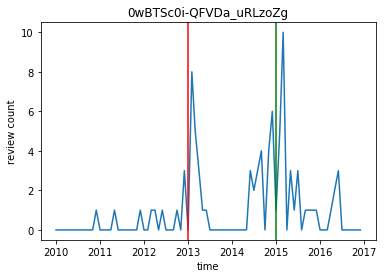

In [27]:
# plot review count over time, red line is the beginning of potnetial period, green line is the beginning of slack period
plt.xlabel('time')
plt.ylabel('review count')
plt.title('0wBTSc0i-QFVDa_uRLzoZg')
plt.plot(t,d)
potential = sample_data.ix[sample_data['user_id'] == '0wBTSc0i-QFVDa_uRLzoZg']['potential_period'].values
slack = sample_data.ix[sample_data['user_id'] == '0wBTSc0i-QFVDa_uRLzoZg']['slack_period'].values
for i in potential[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'r')
for i in slack[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'g')

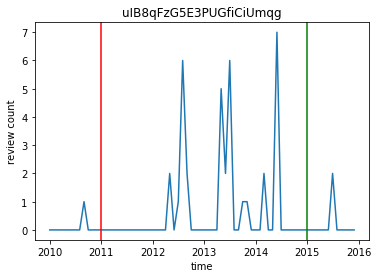

In [28]:
t,d,s,a,w,c,u,f,a_w,a_c,a_f,a_u, a_s  = plotData('uIB8qFzG5E3PUGfiCiUmqg')
plt.close()
plt.xlabel('time')
plt.ylabel('review count')
plt.title('uIB8qFzG5E3PUGfiCiUmqg')
plt.plot(t,d)
potential = sample_data.ix[sample_data['user_id'] == 'uIB8qFzG5E3PUGfiCiUmqg']['potential_period'].values
slack = sample_data.ix[sample_data['user_id'] == 'uIB8qFzG5E3PUGfiCiUmqg']['slack_period'].values
for i in potential[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'r')
for i in slack[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'g')

In [29]:
sample_data.ix[sample_data['user_id'] == 'aU8saUu9QhSFvnYeUsxO-A']['slack_period'].values[0]

['2013', '2015']

In [30]:
for i in range(50):
    u_id = sample_data.iloc[i]['user_id']
    potential = sample_data.ix[sample_data['user_id'] == u_id]['potential_period'].values
    slack = sample_data.ix[sample_data['user_id'] == u_id]['slack_period'].values

    t,d,s,a,w,c,u,f,a_w,a_c,a_f,a_u,a_s  = plotData(u_id)
   
    plt.xlabel('time')
    plt.ylabel('review count')
    plt.title(u_id)
    plt.plot(t,d)
    for j in potential[0]:
        plt.axvline(x = datetime.datetime(int(j),1,1), color = 'r')
    for k in slack[0]:
        plt.axvline(x = datetime.datetime(int(k),1,1), color = 'g')
    
#     plt.savefig('images/'+ str(i) +'.png')
    plt.close()

In [31]:
t,d,s,a,w,c,u,f,a_w,a_c,a_f,a_u,a_s  = plotData('OoyQYSeYNyRVOmdO3tsxYA')

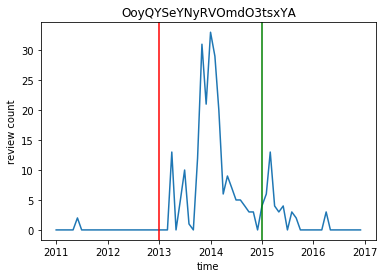

In [32]:
plt.xlabel('time')
plt.ylabel('review count')
plt.title('OoyQYSeYNyRVOmdO3tsxYA')
plt.plot(t,d)
potential = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['potential_period'].values
slack = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['slack_period'].values
for i in potential[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'r')
for i in slack[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'g')

In [33]:
t,d,s,a,w,c,u,f,a_w,a_c,a_f,a_u, a_s = plotData('OoyQYSeYNyRVOmdO3tsxYA')

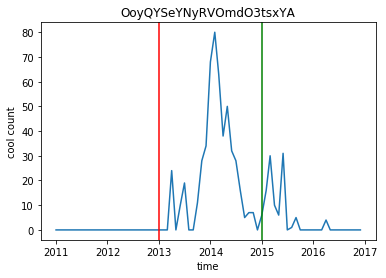

In [34]:
plt.xlabel('time')
plt.ylabel('cool count')
plt.title('OoyQYSeYNyRVOmdO3tsxYA')
plt.plot(t,c)
potential = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['potential_period'].values
slack = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['slack_period'].values
for i in potential[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'r')
for i in slack[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'g')

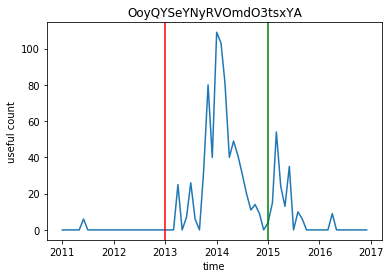

In [35]:
plt.xlabel('time')
plt.ylabel('useful count')
plt.title('OoyQYSeYNyRVOmdO3tsxYA')
plt.plot(t,u)
potential = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['potential_period'].values
slack = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['slack_period'].values
for i in potential[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'r')
for i in slack[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'g')

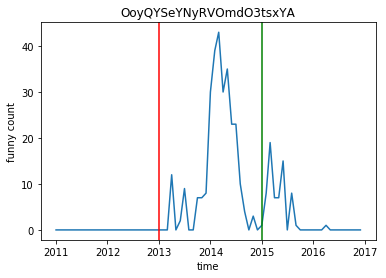

In [36]:
plt.xlabel('time')
plt.ylabel('funny count')
plt.title('OoyQYSeYNyRVOmdO3tsxYA')
plt.plot(t,f)
potential = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['potential_period'].values
slack = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['slack_period'].values
for i in potential[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'r')
for i in slack[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'g')

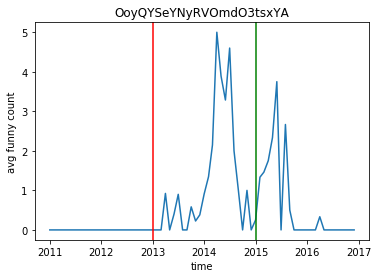

In [37]:
plt.xlabel('time')
plt.ylabel('avg funny count')
plt.title('OoyQYSeYNyRVOmdO3tsxYA')
plt.plot(t,a_f)
potential = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['potential_period'].values
slack = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['slack_period'].values
for i in potential[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'r')
for i in slack[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'g')

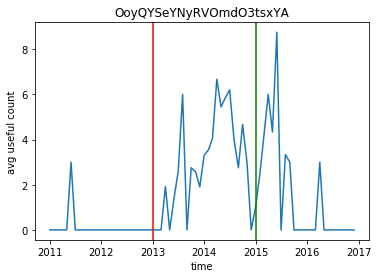

In [38]:
plt.xlabel('time')
plt.ylabel('avg useful count')
plt.title('OoyQYSeYNyRVOmdO3tsxYA')
plt.plot(t,a_u)
potential = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['potential_period'].values
slack = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['slack_period'].values
for i in potential[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'r')
for i in slack[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'g')

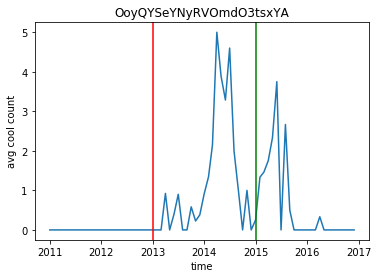

In [39]:
plt.xlabel('time')
plt.ylabel('avg cool count')
plt.title('OoyQYSeYNyRVOmdO3tsxYA')
plt.plot(t,a_f)
potential = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['potential_period'].values
slack = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['slack_period'].values
for i in potential[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'r')
for i in slack[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'g')

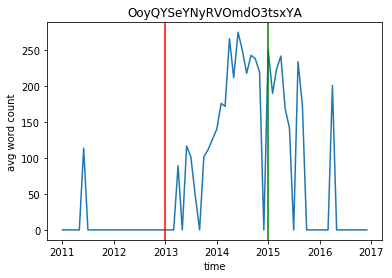

In [40]:
plt.xlabel('time')
plt.ylabel('avg word count')
plt.title('OoyQYSeYNyRVOmdO3tsxYA')
plt.plot(t,a_w)
potential = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['potential_period'].values
slack = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['slack_period'].values
for i in potential[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'r')
for i in slack[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'g')

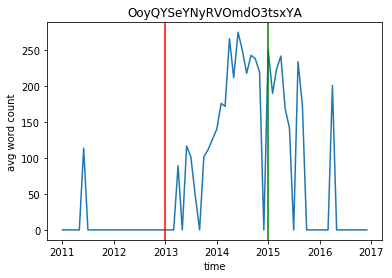

In [41]:
plt.xlabel('time')
plt.ylabel('avg word count')
plt.title('OoyQYSeYNyRVOmdO3tsxYA')
plt.plot(t,a_w)
potential = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['potential_period'].values
slack = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['slack_period'].values
for i in potential[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'r')
for i in slack[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'g')

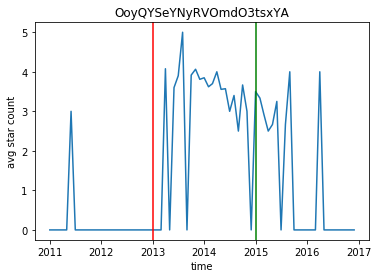

In [42]:
plt.xlabel('time')
plt.ylabel('avg star count')
plt.title('OoyQYSeYNyRVOmdO3tsxYA')
plt.plot(t,a_s)
potential = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['potential_period'].values
slack = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['slack_period'].values
for i in potential[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'r')
for i in slack[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'g')

In [43]:
import time 
int(time.mktime(t[0].timetuple()))

1293858000

In [46]:
from sklearn.preprocessing import normalize
dn = np.asarray(d).reshape(-1,1)
dn = normalize(dn, axis=0).ravel()

In [47]:
def drawGraph(user):
    t,d,s,a,w,c,u,f,a_w,a_c,a_f,a_u, a_s = plotData(user)
    t = [int(time.mktime(x.timetuple())) for x in t]
    dn = np.asarray(d).reshape(-1,1)
    dn = normalize(dn, axis=0).ravel()
    un = np.asarray(u).reshape(-1,1)
    un = normalize(un, axis=0).ravel()
    fn = np.asarray(f).reshape(-1,1)
    fn = normalize(fn, axis=0).ravel()
    cn = np.asarray(c).reshape(-1,1)
    cn = normalize(cn, axis=0).ravel()
    plt.close()
    plt.plot(t,dn, alpha = 0.6)
    plt.plot(t,un, alpha = 0.6)
    plt.plot(t,fn, alpha = 0.6)
    plt.plot(t,cn, alpha = 0.6)
    potential = sample_data.ix[sample_data['user_id'] == user]['potential_period'].values
    slack = sample_data.ix[sample_data['user_id'] == user]['slack_period'].values
    for i in potential[0]:
        plt.axvline(x = int(time.mktime(datetime.datetime(int(i),1,1).timetuple())), color = 'r')
    for i in slack[0]:
        plt.axvline(x = int(time.mktime(datetime.datetime(int(i),1,1).timetuple())), color = 'g')
#     plt.savefig('images/'+ user +'.png')

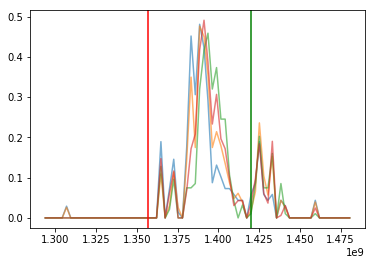

In [48]:
dn = np.asarray(d).reshape(-1,1)
dn = normalize(dn, axis=0).ravel()
un = np.asarray(u).reshape(-1,1)
un = normalize(un, axis=0).ravel()
fn = np.asarray(f).reshape(-1,1)
fn = normalize(fn, axis=0).ravel()
cn = np.asarray(c).reshape(-1,1)
cn = normalize(cn, axis=0).ravel()
t = [int(time.mktime(x.timetuple())) for x in t]
plt.plot(t,dn, alpha = 0.6)
plt.plot(t,un, alpha = 0.6)
plt.plot(t,fn, alpha = 0.6)
plt.plot(t,cn, alpha = 0.6)
potential = sample_data.ix[sample_data['user_id'] == '0wBTSc0i-QFVDa_uRLzoZg']['potential_period'].values
slack = sample_data.ix[sample_data['user_id'] == '0wBTSc0i-QFVDa_uRLzoZg']['slack_period'].values
for i in potential[0]:
    plt.axvline(x = int(time.mktime(datetime.datetime(int(i),1,1).timetuple())), color = 'r')
for i in slack[0]:
    plt.axvline(x = int(time.mktime(datetime.datetime(int(i),1,1).timetuple())), color = 'g')

In [49]:
group = review_df.groupby(['user_id']).count().sort(['review_id'], ascending = False)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [50]:
nameList = np.unique(group.ix[group['review_id'] > 19].stack().index.droplevel(-1))

In [51]:
names = np.intersect1d(np.array(sample_data['user_id']), nameList)

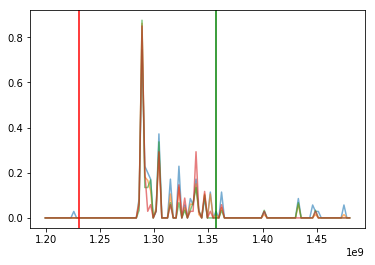

In [52]:
drawGraph(names[0])

## Regression models
Apply regression algorithm to detect the anomalies

In [62]:
from sklearn.svm import SVR
svr_rbf = SVR(kernel='rbf', C=0.01, gamma=0.1)
y_rbf = svr_rbf.fit(np.asarray(t).reshape(-1,1), np.asarray(d)).predict(np.asarray(t).reshape(-1,1))

In [63]:
y_rbf

array([ 0.10011364,  0.10011364,  0.10011364,  0.10011364,  0.10011364,
        0.11636364,  0.10011364,  0.10011364,  0.10011364,  0.10011364,
        0.10011364,  0.10011364,  0.10011364,  0.10011364,  0.10011364,
        0.10011364,  0.10011364,  0.09948864,  0.09948864,  0.09948864,
        0.09948864,  0.10011364,  0.10011364,  0.10011364,  0.10011364,
        0.10011364,  0.10011364,  0.11636364,  0.10011364,  0.11636364,
        0.11636364,  0.11636364,  0.10011364,  0.11636364,  0.11636364,
        0.11636364,  0.11636364,  0.11636364,  0.11636364,  0.11636364,
        0.11636364,  0.11636364,  0.11636364,  0.11636364,  0.11636364,
        0.11636364,  0.11636364,  0.10011364,  0.11636364,  0.11636364,
        0.11636364,  0.11636364,  0.11636364,  0.11636364,  0.10011364,
        0.11636364,  0.11636364,  0.10011364,  0.10011364,  0.10011364,
        0.10011364,  0.10011364,  0.10011364,  0.11636364,  0.10011364,
        0.10011364,  0.10011364,  0.10011364,  0.09948864,  0.09

Create images for the demo

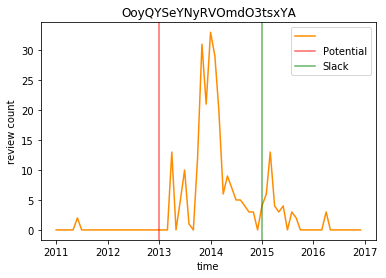

In [125]:
plt.xlabel('time')
plt.ylabel('review count')
plt.title('OoyQYSeYNyRVOmdO3tsxYA')
plt.plot([pd.to_datetime(i* 1000000000) for i in t],d, color = 'darkorange')
potential = sample_data.ix[sample_data['user_id'] == '0wBTSc0i-QFVDa_uRLzoZg']['potential_period'].values
slack = sample_data.ix[sample_data['user_id'] == '0wBTSc0i-QFVDa_uRLzoZg']['slack_period'].values
for i in potential[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'r', alpha = 0.6)
for i in slack[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'g', alpha = 0.6)
plt.legend(['','Potential','Slack'])
plt.savefig('images/'+ 'demo1' +'.png')

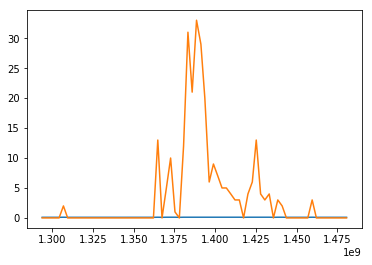

In [64]:
plt.plot(t,y_rbf)
plt.plot(t,d)

In [134]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

print(explained_variance_score(d, y_rbf))
print(mean_absolute_error(d,y_rbf))
print(mean_squared_error(d,y_rbf))
print(median_absolute_error(d,y_rbf))
print(r2_score(d,y_rbf))

0.0132146565779
3.62790250452
63.8611370869
0.100060773152
-0.221938509851


In [138]:
from sklearn.model_selection import GridSearchCV
svr_rbf = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
# svr_rbf = SVR(kernel='rbf', C=0.01, gamma=0.1)
y_rbf = svr_rbf.fit(np.asarray(t).reshape(-1,1), dn).predict(np.asarray(t).reshape(-1,1))

0.669476581861
0.0869319674734
0.00809322820228
0.100007891598
0.270772259103


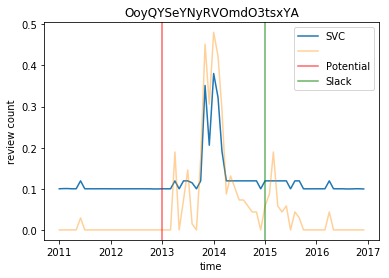

In [140]:
plt.xlabel('time')
plt.ylabel('review count')
plt.title('OoyQYSeYNyRVOmdO3tsxYA')
plt.plot([pd.to_datetime(i* 1000000000) for i in t],y_rbf)
plt.plot([pd.to_datetime(i* 1000000000) for i in t],dn, color = 'darkorange', alpha = 0.4)
potential = sample_data.ix[sample_data['user_id'] == '0wBTSc0i-QFVDa_uRLzoZg']['potential_period'].values
slack = sample_data.ix[sample_data['user_id'] == '0wBTSc0i-QFVDa_uRLzoZg']['slack_period'].values
for i in potential[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'r', alpha = 0.6)
for i in slack[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'g', alpha = 0.6)
plt.legend(['SVC','','Potential','Slack'])
print(explained_variance_score(dn, y_rbf))
print(mean_absolute_error(dn,y_rbf))
print(mean_squared_error(dn,y_rbf))
print(median_absolute_error(dn,y_rbf))
print(r2_score(dn,y_rbf))
# plt.savefig('images/'+ 'svc' +'.png')

In [205]:
from sklearn.tree import DecisionTreeRegressor
DTregr = DecisionTreeRegressor(max_depth=3)
y_dt = DTregr.fit(np.asarray(t).reshape(-1,1), dn).predict(np.asarray(t).reshape(-1,1))

0.871099911468
0.0211957403366
0.00143057891695
0.871099911468


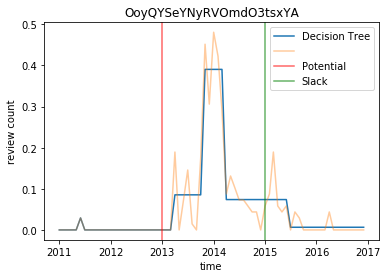

In [206]:
plt.plot([pd.to_datetime(i* 1000000000) for i in t],y_dt)
plt.plot([pd.to_datetime(i* 1000000000) for i in t],dn, alpha = 0.4)
plt.xlabel('time')
plt.ylabel('review count')
plt.title('OoyQYSeYNyRVOmdO3tsxYA')
potential = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['potential_period'].values
slack = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['slack_period'].values
for i in potential[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'r', alpha = 0.6)
for i in slack[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'g', alpha = 0.6)
plt.legend(['Decision Tree','','Potential','Slack'])
print(explained_variance_score(dn, y_dt))
print(mean_absolute_error(dn,y_dt))
print(mean_squared_error(dn,y_dt))
print(r2_score(dn,y_dt))
# plt.savefig('images/'+ 'DT' +'.png')

In [106]:
from sklearn.kernel_ridge import KernelRidge
kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})
y_kr = kr.fit(np.asarray(t).reshape(-1,1), dn).predict(np.asarray(t).reshape(-1,1))

0.693470751977
0.0259835719166
0.00405110309151
0.634981656055


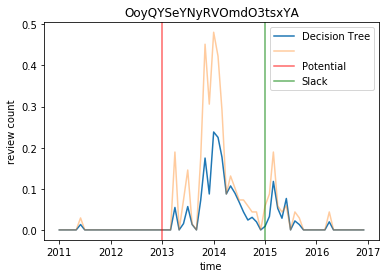

In [162]:
plt.plot([pd.to_datetime(i* 1000000000) for i in t],y_kr)
plt.plot([pd.to_datetime(i* 1000000000) for i in t],dn, alpha = 0.4)
for i in potential[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'r', alpha = 0.6)
for i in slack[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'g', alpha = 0.6)
plt.xlabel('time')
plt.ylabel('review count')
plt.title('OoyQYSeYNyRVOmdO3tsxYA')
plt.legend(['Decision Tree','','Potential','Slack'])
print(explained_variance_score(dn, y_kr))
print(mean_absolute_error(dn,y_kr))
print(mean_squared_error(dn,y_kr))
print(r2_score(dn,y_kr))
# plt.savefig('images/'+ 'kernel' +'.png')

In [108]:
kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})
y_kr = kr.fit(np.asarray(t).reshape(-1,1), un).predict(np.asarray(t).reshape(-1,1))

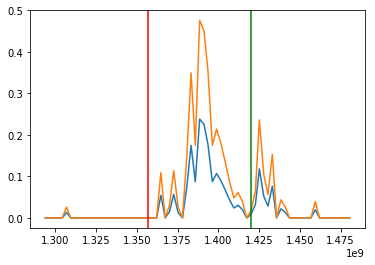

In [109]:
plt.plot(t,y_kr)
plt.plot(t,un)
potential = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['potential_period'].values
slack = sample_data.ix[sample_data['user_id'] == 'OoyQYSeYNyRVOmdO3tsxYA']['slack_period'].values
for i in potential[0]:
    plt.axvline(x = int(time.mktime(datetime.datetime(int(i),1,1).timetuple())), color = 'r')
for i in slack[0]:
    plt.axvline(x = int(time.mktime(datetime.datetime(int(i),1,1).timetuple())), color = 'g')

## Anomaly Detection

In [110]:
from scipy import stats

In [111]:
interval = stats.t.interval(0.99, len((dn-y_kr))-1, loc=np.mean((dn-y_kr)), scale=stats.sem((dn-y_kr)))
interval

(0.0071563052256200035, 0.043799861772249843)

In [112]:
interval = stats.t.interval(0.99, len((dn-y_dt))-1, loc=np.mean((dn-y_dt)), scale=stats.sem((dn-y_dt)))
interval

(-0.011881144312608477, 0.011881144312608463)

In [113]:
anomX = []
anomY = []
for i in range(len(dn-y_kr)):
    if (dn-y_kr)[i] > interval[1]:
        anomX.append(t[i])
        anomY.append(dn[i])

In [115]:
PanomX = []
PanomY = []
NanomX = []
NanomY = []
for i in range(len(dn-y_dt)):
    if (dn-y_dt)[i] > interval[1]:
        PanomX.append(t[i])
        PanomY.append(dn[i])
for i in range(len(dn-y_dt)):
    if (dn-y_dt)[i] < interval[0]:
        NanomX.append(t[i])
        NanomY.append(dn[i])

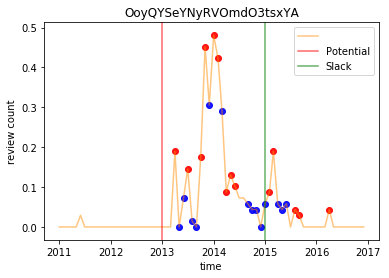

In [158]:
plt.xlabel('time')
plt.ylabel('review count')
plt.title('OoyQYSeYNyRVOmdO3tsxYA')
plt.plot([pd.to_datetime(i* 1000000000) for i in t],dn, color = "darkorange", alpha = 0.5)
plt.scatter([pd.to_datetime(i* 1000000000) for i in PanomX],PanomY, color = 'r', alpha = 0.9)
plt.scatter([pd.to_datetime(i* 1000000000) for i in NanomX],NanomY, color = 'b', alpha = 0.9)
potential = sample_data.ix[sample_data['user_id'] == '0wBTSc0i-QFVDa_uRLzoZg']['potential_period'].values
slack = sample_data.ix[sample_data['user_id'] == '0wBTSc0i-QFVDa_uRLzoZg']['slack_period'].values
for i in potential[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'r', alpha = 0.6)
for i in slack[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'g', alpha = 0.6)
plt.legend(['','Potential','Slack'])
# plt.savefig('images/anom.png')

In [314]:
def anomalieDetection(user, data = 'review', plot = True, plotReg = False, save = False):
    plt.close()
    t,d,s,a,w,c,u,f,a_w,a_c,a_f,a_u,a_s  = plotData(user)
    y = d
    if (data == 'funny'):
        y = f
    elif (data == 'useful'):
        y = u
    elif (data == 'cool'):
        y = c
    y = np.asarray(y).reshape(-1,1)
    y = normalize(y, axis=0).ravel()
    t = [int(time.mktime(x.timetuple())) for x in t]
    kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})
    y_kr = kr.fit(np.asarray(t).reshape(-1,1), y).predict(np.asarray(t).reshape(-1,1))
    interval = stats.t.interval(0.99, len((y-y_kr))-1, loc=np.mean((y-y_kr)), scale=stats.sem((y-y_kr)))
    anomX = []
    anomY = []
    for i in range(len(y-y_kr)):
        if (y-y_kr)[i] > interval[1]:
            anomX.append(t[i])
            anomY.append(y[i])
    if (plotReg):
        plt.plot([pd.to_datetime(i) for i in t],y_kr)
    if (plot):
        potential = sample_data.ix[sample_data['user_id'] == user]['potential_period'].values
        slack = sample_data.ix[sample_data['user_id'] == user]['slack_period'].values
        for i in potential[0]:
            plt.axvline(x = datetime.datetime(int(i),1,1), color = 'r')
        for i in slack[0]:
            plt.axvline(x = datetime.datetime(int(i),1,1), color = 'g')

        plt.plot([pd.to_datetime(i * 1000000000) for i in t],y)
        plt.scatter([pd.to_datetime(i * 1000000000) for i in anomX],anomY, color = 'r', alpha = 0.6)
    if (save):
        plt.savefig('images/'+ user +'.anom.png')
    return [pd.to_datetime(i * 1000000000) for i in t],y, [pd.to_datetime(i * 1000000000) for i in anomX], anomY

In [242]:
def measureTimeDelta(user):
    X,Y = anomalieDetection(user, plot = False)
    first_spike = X[0].year
    potential = int(sample_data.ix[sample_data['user_id'] == user]['potential_period'].values[0][0])
    return first_spike - potential

In [283]:
def PNanomalieDetection(user, data = 'review', plot = True, plotReg = False, save = False):
    plt.close()
    t,d,s,a,w,c,u,f,a_w,a_c,a_f,a_u,a_s  = plotData(user)
    y = d
    if (data == 'funny'):
        y = a_f
    elif (data == 'useful'):
        y = a_u
    elif (data == 'cool'):
        y = a_c
    y = np.asarray(y).reshape(-1,1)
    y = normalize(y, axis=0).ravel()
    t = [int(time.mktime(x.timetuple())) for x in t]
    DTregr = DecisionTreeRegressor(max_depth=3)
    y_dt = DTregr.fit(np.asarray(t).reshape(-1,1), y).predict(np.asarray(t).reshape(-1,1))
    interval = stats.t.interval(0.99, len((y-y_dt))-1, loc=np.mean((y-y_dt)), scale=stats.sem((y-y_dt)))
    PanomX = []
    PanomY = []
    NanomX = []
    NanomY = []
    for i in range(len(y-y_dt)):
        if (y-y_dt)[i] > interval[1]:
            PanomX.append(t[i])
            PanomY.append(y[i])
    for i in range(len(y-y_dt)):
        if (y-y_dt)[i] < interval[0]:
            NanomX.append(t[i])
            NanomY.append(y[i])
    if (plotReg):
        plt.plot([pd.to_datetime(i) for i in t],y_kr)
    if (plot):
        potential = sample_data.ix[sample_data['user_id'] == user]['potential_period'].values
        slack = sample_data.ix[sample_data['user_id'] == user]['slack_period'].values
        for i in potential[0]:
            plt.axvline(x = datetime.datetime(int(i),1,1), color = 'r')
        for i in slack[0]:
            plt.axvline(x = datetime.datetime(int(i),1,1), color = 'g')

        plt.plot([pd.to_datetime(i* 1000000000) for i in t],y, color = "darkorange")
        plt.scatter([pd.to_datetime(i* 1000000000) for i in PanomX],PanomY, color = 'r', alpha = 0.6)
        plt.scatter([pd.to_datetime(i* 1000000000) for i in NanomX],NanomY, color = 'b', alpha = 0.6)
    if (save):
        plt.savefig('images/'+ user +'.anom.png')
    return [pd.to_datetime(i * 1000000000) for i in PanomX], PanomY, \
            [pd.to_datetime(i * 1000000000) for i in NanomX], NanomY

# Kernel Density Estimation

In [256]:
t_s = [time.mktime(i.timetuple()) for i in x]

In [257]:
a = np.array(t_s).reshape(-1, 1) # anormalie

In [259]:
s_l = np.linspace(t_s[0], t_s[len(t_s)-1], len(t_s)) 

In [263]:
from sklearn.neighbors.kde import KernelDensity
grid = GridSearchCV(KernelDensity(),
                            {'bandwidth': np.linspace(0.1, 1.0, 20)}) # 20-fold cross-validation
grid.fit(a)

GridSearchCV(cv=None, error_score='raise',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'bandwidth': array([ 0.1    ,  0.14737,  0.19474,  0.24211,  0.28947,  0.33684,
        0.38421,  0.43158,  0.47895,  0.52632,  0.57368,  0.62105,
        0.66842,  0.71579,  0.76316,  0.81053,  0.85789,  0.90526,
        0.95263,  1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [265]:
kde = grid.best_estimator_
e_l = kde.score_samples(s_l.reshape(-1,1))  

In [270]:
from scipy.signal import argrelextrema
mi_l, ma_l = argrelextrema(e_l, np.less)[0], argrelextrema(e_l, np.greater)[0]

In [274]:
cluster_l = []
if not mi_l.size == 0:
    for i in range(mi_l.size+1):
        if i == 0:
            for j in range(a[a<s_l[mi_l[i]]].size):
                cluster_l.append(i)
        elif i == mi_l.size:
            for j in range(a[a>=s_l[mi_l[i-1]]].size):
                cluster_l.append(i)
        else:
            for j in range(a[(a < s_l[mi_l[i]]) * (a >= s_l[mi_l[i-1]])].size):
                cluster_l.append(i)

In [368]:
def find_cluster(x):
    t = [time.mktime(i.timetuple()) for i in x]
    a = np.array(t).reshape(-1, 1) # anormalie
    try:
        s = np.linspace(t[0], t[len(t)-1], len(t)) 
        grid = GridSearchCV(KernelDensity(),
                                {'bandwidth': np.linspace(0.1, 1.0, 20)}) # 20-fold cross-validation
        grid.fit(a)
        kde = grid.best_estimator_
        e = kde.score_samples(s.reshape(-1,1)) 
        mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
        cluster_l = []
        if not mi.size == 0:
            for i in range(mi.size+1):
                if i == 0:
                    for j in range(a[a<s[mi[i]]].size):
                        cluster_l.append(i)
                elif i == mi.size:
                    for j in range(a[a>=s[mi[i-1]]].size):
                        cluster_l.append(i)
                else:
                    for j in range(a[(a < s[mi[i]]) * (a >= s[mi[i-1]])].size):
                        cluster_l.append(i)
        return cluster_l
    except:
        cluster_l = []
        for i in range(len(x)):
            cluster_l.append(0)
        return cluster_l

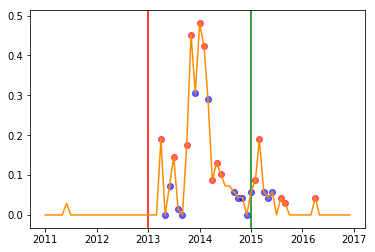

In [303]:
x,y, x2,y2 = PNanomalieDetection('OoyQYSeYNyRVOmdO3tsxYA')

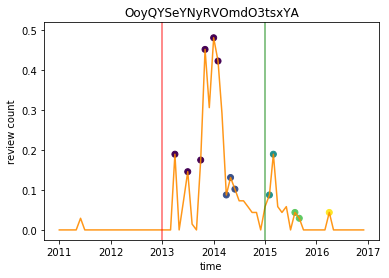

In [344]:
plt.xlabel('time')
plt.ylabel('review count')
plt.title('OoyQYSeYNyRVOmdO3tsxYA')
plt.scatter(a,b,c = find_cluster(a))
plt.plot(t,d, color = 'darkorange', alpha = 0.9)
potential = sample_data.ix[sample_data['user_id'] == '0wBTSc0i-QFVDa_uRLzoZg']['potential_period'].values
slack = sample_data.ix[sample_data['user_id'] == '0wBTSc0i-QFVDa_uRLzoZg']['slack_period'].values
for i in potential[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'r', alpha = 0.6)
for i in slack[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'g', alpha = 0.6)
# plt.savefig('images/'+ 'positive_cluster' +'.anom.png')

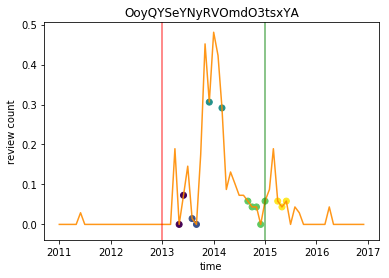

In [336]:
plt.xlabel('time')
plt.ylabel('review count')
plt.title('OoyQYSeYNyRVOmdO3tsxYA')
plt.scatter(x2,y2,c = find_cluster(x2))
plt.plot(t,d, color = 'darkorange', alpha = 0.9)
potential = sample_data.ix[sample_data['user_id'] == '0wBTSc0i-QFVDa_uRLzoZg']['potential_period'].values
slack = sample_data.ix[sample_data['user_id'] == '0wBTSc0i-QFVDa_uRLzoZg']['slack_period'].values
for i in potential[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'r', alpha = 0.6)
for i in slack[0]:
    plt.axvline(x = datetime.datetime(int(i),1,1), color = 'g', alpha = 0.6)
# plt.savefig('images/'+ 'negative_cluster' +'.anom.png')

# Saving all the work 

In [356]:
positive = []
negative = []
for i in range(len(names)): 
    p,y1,n,y2= PNanomalieDetection(names[i], plot = False)
    positive.append(p)    
    negative.append(n)
    if i%500 == 0:
        print(i)

0
500
1000
1500


In [358]:
pd.DataFrame(names, column = ['user_id', ]

array([u'---1lKK3aKOuomHnwAkAow', u'-0IiMAZI2SsQ7VmyzJjokQ',
       u'-2UOdDlzg7XLuUuyOrldhA', ..., u'zsZBYWYEmLLs81_f-HHM8w',
       u'zs_4PkGaPd_BMGkgj30VAA', u'zxA6KTqMirq7EsaIH93LSA'], dtype=object)

In [361]:
d = {'user_id' : names,\
   'positive_spike' : positive,\
    'negative_spike' : negative}

In [372]:
# store everything
pd.DataFrame(d).to_csv('anomalies.csv')

In [369]:
pos_c = [find_cluster(i) for i in positive]

In [371]:
neg_c = [find_cluster(i) for i in negative]

In [373]:
anomaly['pos_cluster'] = pos_c

In [374]:
anomaly['neg_cluster'] = neg_c

In [375]:
anomaly.head()

,negative_spike,positive_spike,user_id,pos_cluster,neg_cluster
0,"[2010-10-01 04:00:00, 2010-12-01 05:00:00, 201...","[2008-11-01 04:00:00, 2010-11-01 04:00:00, 201...",---1lKK3aKOuomHnwAkAow,"[0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 4, 4, 4, 4]","[0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, ..."
1,"[2009-01-01 05:00:00, 2009-02-01 05:00:00, 200...","[2009-07-01 04:00:00, 2009-08-01 04:00:00, 200...",-0IiMAZI2SsQ7VmyzJjokQ,"[0, 0, 0, 0, 1, 2, 2, 2, 3, 4, 4, 4]","[0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, ..."
2,"[2010-01-01 05:00:00, 2010-02-01 05:00:00, 201...","[2010-08-01 04:00:00, 2010-09-01 04:00:00, 201...",-2UOdDlzg7XLuUuyOrldhA,"[0, 0, 0, 1, 1, 1, 1, 2]","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]"
3,"[2010-01-01 05:00:00, 2010-02-01 05:00:00, 201...","[2010-09-01 04:00:00, 2012-02-01 05:00:00, 201...",-9SoHrhiiUVmx6-MkyR4RA,"[0, 1, 1, 2, 2, 2, 2]","[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2]"
4,"[2011-01-01 05:00:00, 2011-03-01 05:00:00, 201...","[2011-06-01 04:00:00, 2011-11-01 04:00:00, 201...",-C1axHDk0GJCiaKvsNR3eA,"[0, 0, 0, 1]","[0, 0, 0, 0, 1, 1]"


In [376]:
anomaly.to_csv('anomalies.csv')

In [ ]:
kernel = []
for i in range(len(names)): 
    t,d,x,y= anomalieDetection(names[i], plot = False) 
    kernel.append(x)
    if i%500 == 0:
        print(i)

0
